## Analysis of Sea Ice Coverage and Sea Surface Temperatures
### 1982 - 2024

These are the libraries necessary for this notebook. We import them below.

In [3]:
import pandas as pd
import numpy as np
import netCDF4 as nc
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.cm as cm
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
from plotnine import *
import time
from IPython.display import display, clear_output

Below, we import the cleaned sea ice data from copernicus. The code used for processing this data is shown in sea_ice_file_reader.ipynb, but as the code takes nearly 8 hours to run and uses up a significant chunk of the jupyter notebook memory, it was necessary to export the files and then import the result below. The cell below defines the file names, dimensions of the files, and an empty dataframe to append them to.

*Note: The data sources we used were not able to be streamed via ibis libraries, but the copernicus library is a similar library that made use of streaming and processing the data using xarray to reduce the memory required to stream our data. See more in the sea_ice_file_reader section.*

In [4]:
file_names = ['1982_1991_monthly_arctic_summary.nc', '1992_2001_monthly_arctic_summary.nc', 
              '2002_2011_monthly_arctic_summary.nc', '2002_2011_monthly_arctic_summary.nc', 
              '2022_2031_monthly_arctic_summary.nc']

dimensions = ['Long_2d', 'Lat_2d', 'Month']

sst_ice_1982_2025 = pd.DataFrame(columns=['Long_2d', 'Lat_2d', 'Month', 
                                          'sea_ice_fraction', 'analysed_st'])

The following cell iterates over the five files exported by sea_ice_file_reader.ipynb (it was necessary to split the data into five files to prevent the processing steps from exceeding 4.0 GB of memory). Each file is imported and empty cells are filled with NaN values. Then, it is converted from its multi-dimensional representation in the .nc files into a two dimensional dataset using the .flatten(), .unstack(), and .melt() methods. Finally, the results for the temperature and sea ice columns are merged and the dataset is appended to the existing  sst_ice_1982_2025 DataFrame. Due to the way the sea_ice_file_reader.ipynb aggregates the data, the Month column of the dataset is months since the first month included in the dataset. Since the datasets are imported in decade chunks, we needed to add 120 months for each decade before aggregation. 

In [5]:
for i in range(len(file_names)):

    path = 'sea_ice_data/' + file_names[i]
    ds = nc.Dataset(path)

    sea_ice = ds['sea_ice_fraction'][:]
    sea_ice = sea_ice.filled(fill_value=np.nan)

    sea_temp = ds['analysed_st'][:]
    sea_temp = sea_temp.filled(fill_value=np.nan)

    index = pd.MultiIndex.from_product([range(s) for s in sea_ice.shape], 
                                       names=dimensions)

    sea_ice_multi = pd.Series(sea_ice.flatten(), index=index)
    sea_ice_3d = sea_ice_multi.unstack(level='Month').reset_index()
    sea_ice_long = pd.melt(sea_ice_3d, id_vars=['Long_2d', 'Lat_2d'], 
                           value_name='sea_ice_fraction')

    sea_temp_multi = pd.Series(sea_temp.flatten(), index=index)
    sea_temp_3d = sea_temp_multi.unstack(level='Month').reset_index()
    sea_temp_long = pd.melt(sea_temp_3d, id_vars=['Long_2d', 'Lat_2d'], 
                            value_name='analysed_st')

    sst_ice_combined = pd.merge(sea_ice_long, sea_temp_long, 
                                on=['Long_2d', 'Lat_2d', 'Month'])
    sst_ice_combined['Month'] = sst_ice_combined['Month'] + 120*i
    
    sst_ice_1982_2025 = pd.concat([sst_ice_1982_2025, sst_ice_combined], ignore_index=True)

sst_ice_1982_2025.head(3)

/tmp/ipykernel_9921/3333804291.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,Long_2d,Lat_2d,Month,sea_ice_fraction,analysed_st
0,0,0,0,0.000000,276.513200
1,0,1,0,0.001760,275.496649
2,0,2,0,0.238276,269.644432


We use the relativedelta library to convert the months since 1982 to datetime values, and then split those into month of year and year columns below.

In [6]:
start_date = datetime(1982, 1, 1, 0, 0, 0)
month = relativedelta(months=1)

sst_ice_1982_2025['datetime'] = sst_ice_1982_2025['Month'].apply(lambda x: start_date + (month * x))
sst_ice_1982_2025['MOY'] = sst_ice_1982_2025['datetime'].apply(lambda x: x.month)
sst_ice_1982_2025['Year'] = sst_ice_1982_2025['datetime'].apply(lambda x: x.year)
sst_ice_1982_2025 = sst_ice_1982_2025.drop(columns=['datetime', 'Month'])

Since the longitude and latitude values are in 2 degree intervals, we need to multiply them by 2 in the cell below to ensure that they properly reflect the latitude and longitude coordinates they represent. The latitude coordinates in the original dataset start at 180 degrees West, which we will represent with a -180 in the latitude column. The cell below makes these adjustments.

In [7]:
sst_ice_1982_2025['Long_2d'] = (sst_ice_1982_2025['Long_2d'] * 2) - 179
sst_ice_1982_2025['Lat_2d'] = sst_ice_1982_2025['Lat_2d'] * 2 + 1
sst_ice_1982_2025.head(3)

,Long_2d,Lat_2d,sea_ice_fraction,analysed_st,MOY,Year
0,-179,1,0.000000,276.513200,1,1982
1,-179,3,0.001760,275.496649,1,1982
2,-179,5,0.238276,269.644432,1,1982


Since there isn't data for all of 2025 yet (this year, as of the completion of this analysis), we filter the dataset for all years before 2025.

In [8]:
sst_ice_1982_2025 = sst_ice_1982_2025[sst_ice_1982_2025['Year'] < 2025]

## Sea and Ice Surface Temperature

In this section, we'll look at the changes in sea surface temperature and ice surface temperature between the years 1982 and 2024. We'll characterize how these temperatures have changed over time and where these changes are most prominent. 

In this first cell, we convert the single latitude and longitude coordinates, which represent the center of each 2 degree latitude by longitude coordinate polygon, into polygons made of the edge coordinates of each of these. This will be important for some of our analyses and graphs later in this notebook. It may take around a minute to run.

In [9]:
sst_ice_1982_2025['geom'] = sst_ice_1982_2025.apply(lambda row: Polygon([(row['Long_2d'] - 1, 
                                                                          row['Lat_2d'] - 1), 
                                (row['Long_2d'] - 1, row['Lat_2d'] + 1), 
                                (row['Long_2d'] + 1, row['Lat_2d'] + 1), 
                                (row['Long_2d'] + 1, row['Lat_2d'] - 1), 
                                (row['Long_2d'] - 1, row['Lat_2d'] - 1)]), axis=1)

In the cell below, we convert the above table into a geodataframe, and then convert into EPSG 3408 (Lambert Azimuthal Equal-Area), which is an equal-area coordinate projection specifically suited for polar regions (this means that each of our 2x2 latitude longitude polygons will be projected to a coordinate system that allows us to accurately calculate the area they take up -- otherwise the area of values closer to the poles will be too large compared to the area they actually take up). 

In [10]:
sst_ice_1982_2025_gdf = gpd.GeoDataFrame(sst_ice_1982_2025, geometry='geom', crs="EPSG:4326")
sst_ice_1982_2025_gdf = sst_ice_1982_2025_gdf.to_crs(epsg=3408)
sst_ice_1982_2025_gdf['area'] = sst_ice_1982_2025_gdf['geom'].area
sst_ice_1982_2025_gdf.head()

,Long_2d,Lat_2d,sea_ice_fraction,analysed_st,MOY,Year,geom,area
0,-179,1,0.000000,276.513200,1,1982,"POLYGON ((-0.000 9010277.047, -0.000 8851653.7...",4.944070e+10
1,-179,3,0.001760,275.496649,1,1982,"POLYGON ((-0.000 8851653.721, -0.000 8690334.0...",4.938047e+10
2,-179,5,0.238276,269.644432,1,1982,"POLYGON ((-0.000 8690334.095, -0.000 8526367.3...",4.926007e+10
3,-179,7,0.836267,257.487240,1,1982,"POLYGON ((-0.000 8526367.310, -0.000 8359803.3...",4.907965e+10
4,-179,9,0.861798,248.560383,1,1982,"POLYGON ((-0.000 8359803.310, -0.000 8190692.8...",4.883944e+10


In the cell below, we generate a summary table by summing up the average total sea ice coverage for each year, and the weighted average of the average surface temperature. We also convert the area from square meters to square kilometers, and the temperature from Kelvin to Celsius, both for human readability.

In [11]:
sst_ice_1982_2025_gdf['ice_area'] = sst_ice_1982_2025_gdf['sea_ice_fraction'] * sst_ice_1982_2025_gdf['area']
sst_ice_1982_2025_gdf['temp_weighted'] = sst_ice_1982_2025_gdf['analysed_st'] * sst_ice_1982_2025_gdf['area']
sst_ice_gdf_clean = sst_ice_1982_2025_gdf.dropna(how='any',axis=0)

annual_stats = sst_ice_gdf_clean.groupby('Year').agg(
    total_sea_ice_area=('ice_area', 'sum'),
    sum_temp_weight=('temp_weighted', 'sum'),
    sum_area=('area', 'sum')
)

annual_stats['avg_sea_ice_temp'] = annual_stats['sum_temp_weight'] / annual_stats['sum_area']
annual_stats = annual_stats.drop(columns=['sum_temp_weight', 'sum_area'])
annual_stats['Total Sea Ice Area (km2)'] = annual_stats['total_sea_ice_area'] / 1000000
annual_stats['Average Sea Ice Temp (C)'] = annual_stats['avg_sea_ice_temp'] - 273.15
annual_stats = annual_stats.reset_index()
annual_stats.head(3)

,Year,total_sea_ice_area,avg_sea_ice_temp,Total Sea Ice Area (km2),Average Sea Ice Temp (C)
0,1982,8.272240e+14,260.159066,8.272240e+08,-12.990934
1,1983,8.107166e+14,259.923444,8.107166e+08,-13.226556
2,1984,7.964276e+14,260.836304,7.964276e+08,-12.313696


In the cell below, we plot the surface temperature data. 

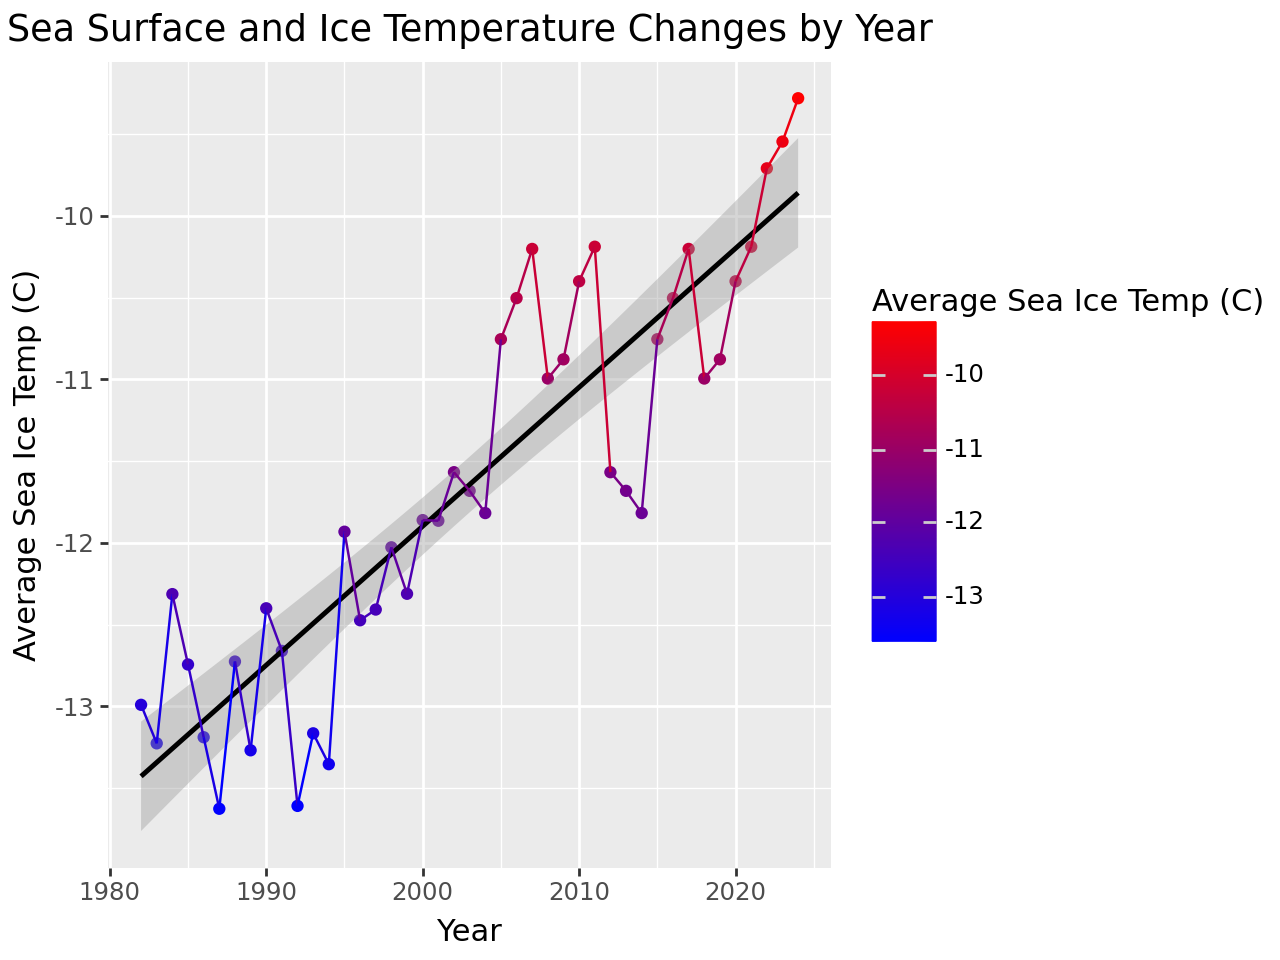

In [13]:
sst_plot = (ggplot(annual_stats, aes(x='Year', 
                                     y='Average Sea Ice Temp (C)', 
                                     color='Average Sea Ice Temp (C)')) 
            + geom_point() 
            + geom_smooth(method='lm') 
            + geom_line() 
            + labs(title = "Sea Surface and Ice Temperature Changes by Year")
            + scale_color_gradient(low='blue', high='red'))
sst_plot

Above, we can clearly see that the average surface temperature of sea ice and surface ocean across the arctic region has increased by over 4 degrees celsius since 1982. This is far greater than the amount the Earth has warmed on average since 1982, which is reflective of the general trend of polar regions warming faster than the average rate of global warming. 

Now let's see whether this trend is more significant in some months than in others. We complete the same processing steps as above, but aggregate over months instead of over years.

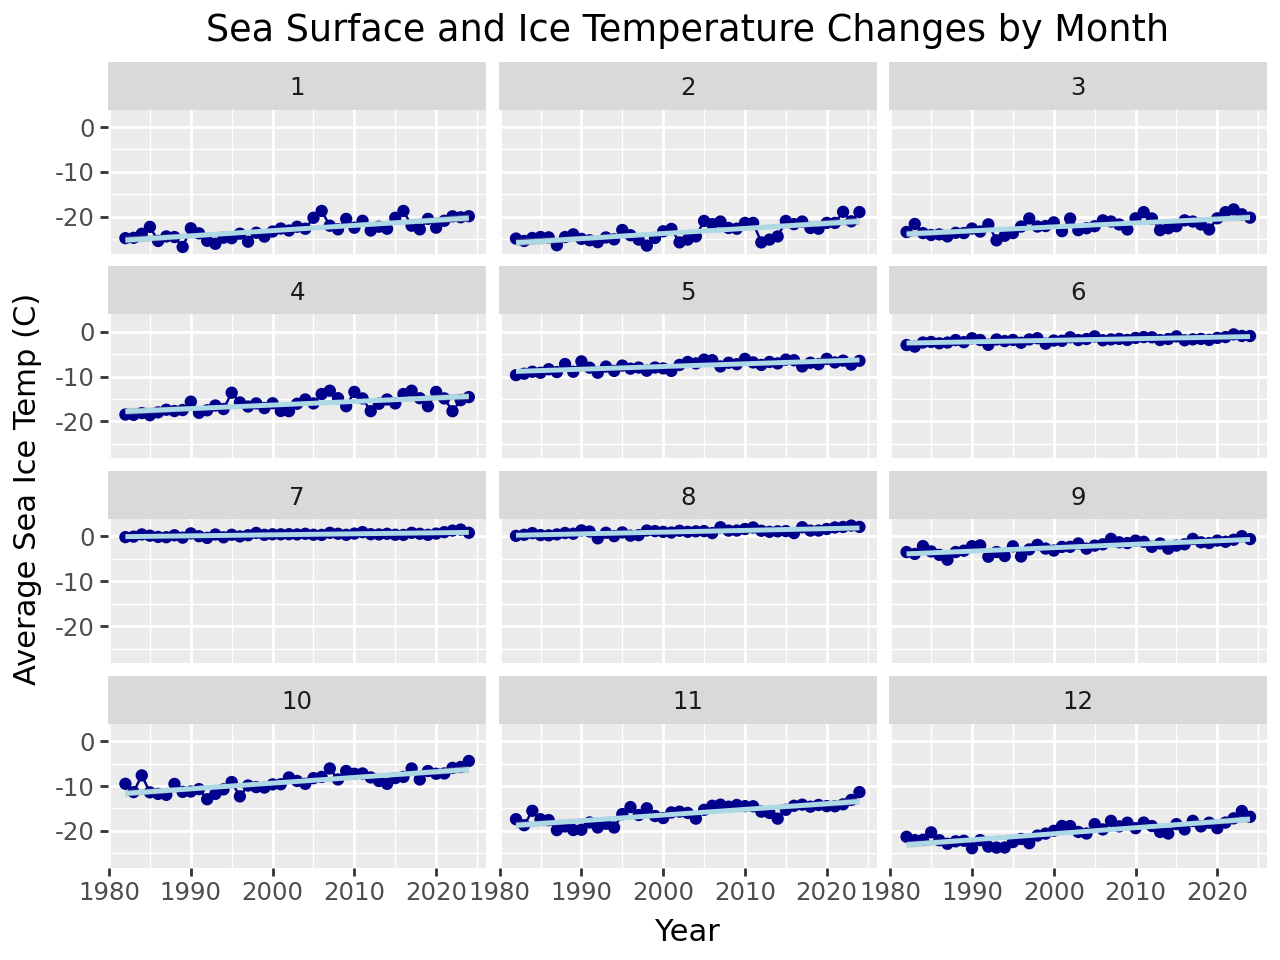

In [14]:
monthly_stats = sst_ice_gdf_clean.groupby(['Year', 'MOY']).agg(
    total_sea_ice_area=('ice_area', 'sum'),
    sum_temp_weight=('temp_weighted', 'sum'),
    sum_area=('area', 'sum')
).reset_index()

monthly_stats['avg_sea_ice_temp'] = monthly_stats['sum_temp_weight'] / monthly_stats['sum_area']
monthly_stats = monthly_stats.drop(columns=['sum_temp_weight', 'sum_area'])
monthly_stats['Total Sea Ice Area (km2)'] = monthly_stats['total_sea_ice_area'] / 1000000
monthly_stats['Average Sea Ice Temp (C)'] = monthly_stats['avg_sea_ice_temp'] - 273.15

monthly_st = (ggplot(monthly_stats, aes(x='Year', y='Average Sea Ice Temp (C)')) 
              + facet_wrap('MOY', ncol=3) + geom_point(color='darkblue') 
              + geom_line(color='darkblue') 
              + geom_smooth(method='lm', color="lightblue") 
              + labs(title = "Sea Surface and Ice Temperature Changes by Month"))
monthly_st

While the summer months have the warmest temperatures overall, the temperature increases are most prominent in the winter months, with January, February, March, October, November, and December all showing increases in the range of 5 degrees Celsius. The melting point of sea ice is around -1.8 C due to its salinity -- if this trend continues, the average surface temperature of the entire Arctic region could be *above the freezing point of sea ice by the end of the century.*

Next, let's explore which regions are affected most seriously by these changes. Since neither 1982 nor 2024 appear to be particularly anomalous (both datapoints are close to the trendline), we will simply compare the changes between 1982 and 2024 as a proxy for how the temperatures have changed overall.  

We'll start by computing the difference between each longitude and latitude parcel for each month between each of these two years. We will compute this for both sea ice and surface temperature for simplicity, but we will not look at sea ice coverage until the next section.

In [37]:
mapped_1982 = sst_ice_1982_2025_gdf[sst_ice_1982_2025_gdf['Year']==1982]
mapped_2024 = sst_ice_1982_2025_gdf[sst_ice_1982_2025_gdf['Year']==2024]

merged = pd.merge(mapped_2024, mapped_1982, on=['Long_2d', 'Lat_2d', 'geom', 'MOY'])
merged['difference_ice'] = merged['sea_ice_fraction_y'] - merged['sea_ice_fraction_x']
merged['difference_sst'] = merged['analysed_st_y'] - merged['analysed_st_x']
merged = merged[['Long_2d', 'Lat_2d', 'MOY', 'geom', 'difference_ice', 'difference_sst']]
merged.head()

,Long_2d,Lat_2d,MOY,geom,difference_ice,difference_sst
0,-179,1,1,"POLYGON ((-0.000 9010277.047, -0.000 8851653.7...",0.000000,0.036945
1,-179,3,1,"POLYGON ((-0.000 8851653.721, -0.000 8690334.0...",-0.004825,0.660728
2,-179,5,1,"POLYGON ((-0.000 8690334.095, -0.000 8526367.3...",-0.373131,5.051972
3,-179,7,1,"POLYGON ((-0.000 8526367.310, -0.000 8359803.3...",-0.042408,-1.493222
4,-179,9,1,"POLYGON ((-0.000 8359803.310, -0.000 8190692.8...",0.103829,-4.051921


Below, we create a color gradient for both the difference in ice and difference in surface temperature defined in the above cell. We use the matplotlib color libraries for each. This cell may take around thirty seconds to run. 

In [48]:
cmap = plt.get_cmap('RdBu').reversed()
norm = Normalize(vmin=merged['difference_sst'].min(), vmax=merged['difference_sst'].max())
merged['fill_sst_diff'] = merged['difference_sst'].apply(lambda x: rgb2hex(cmap(norm(x))))
merged.head()

cmap = plt.get_cmap('BrBG').reversed()
norm = Normalize(vmin=-1, vmax=1)
merged['fill_ice_diff'] = merged['difference_ice'].apply(lambda x: rgb2hex(cmap(norm(x))))

In the cell below we define a dictionary that will make our month data more reader friendly, and define the shape of our output graphic. 

In [60]:
month_dict = {1: "January", 2: "February", 3: "March", 
              4: "April", 5: "May", 6: "June", 
              7: "July", 8: "August", 9: "September", 
              10: "October", 11: "November", 12: "December"}

rows = 12
columns = 1

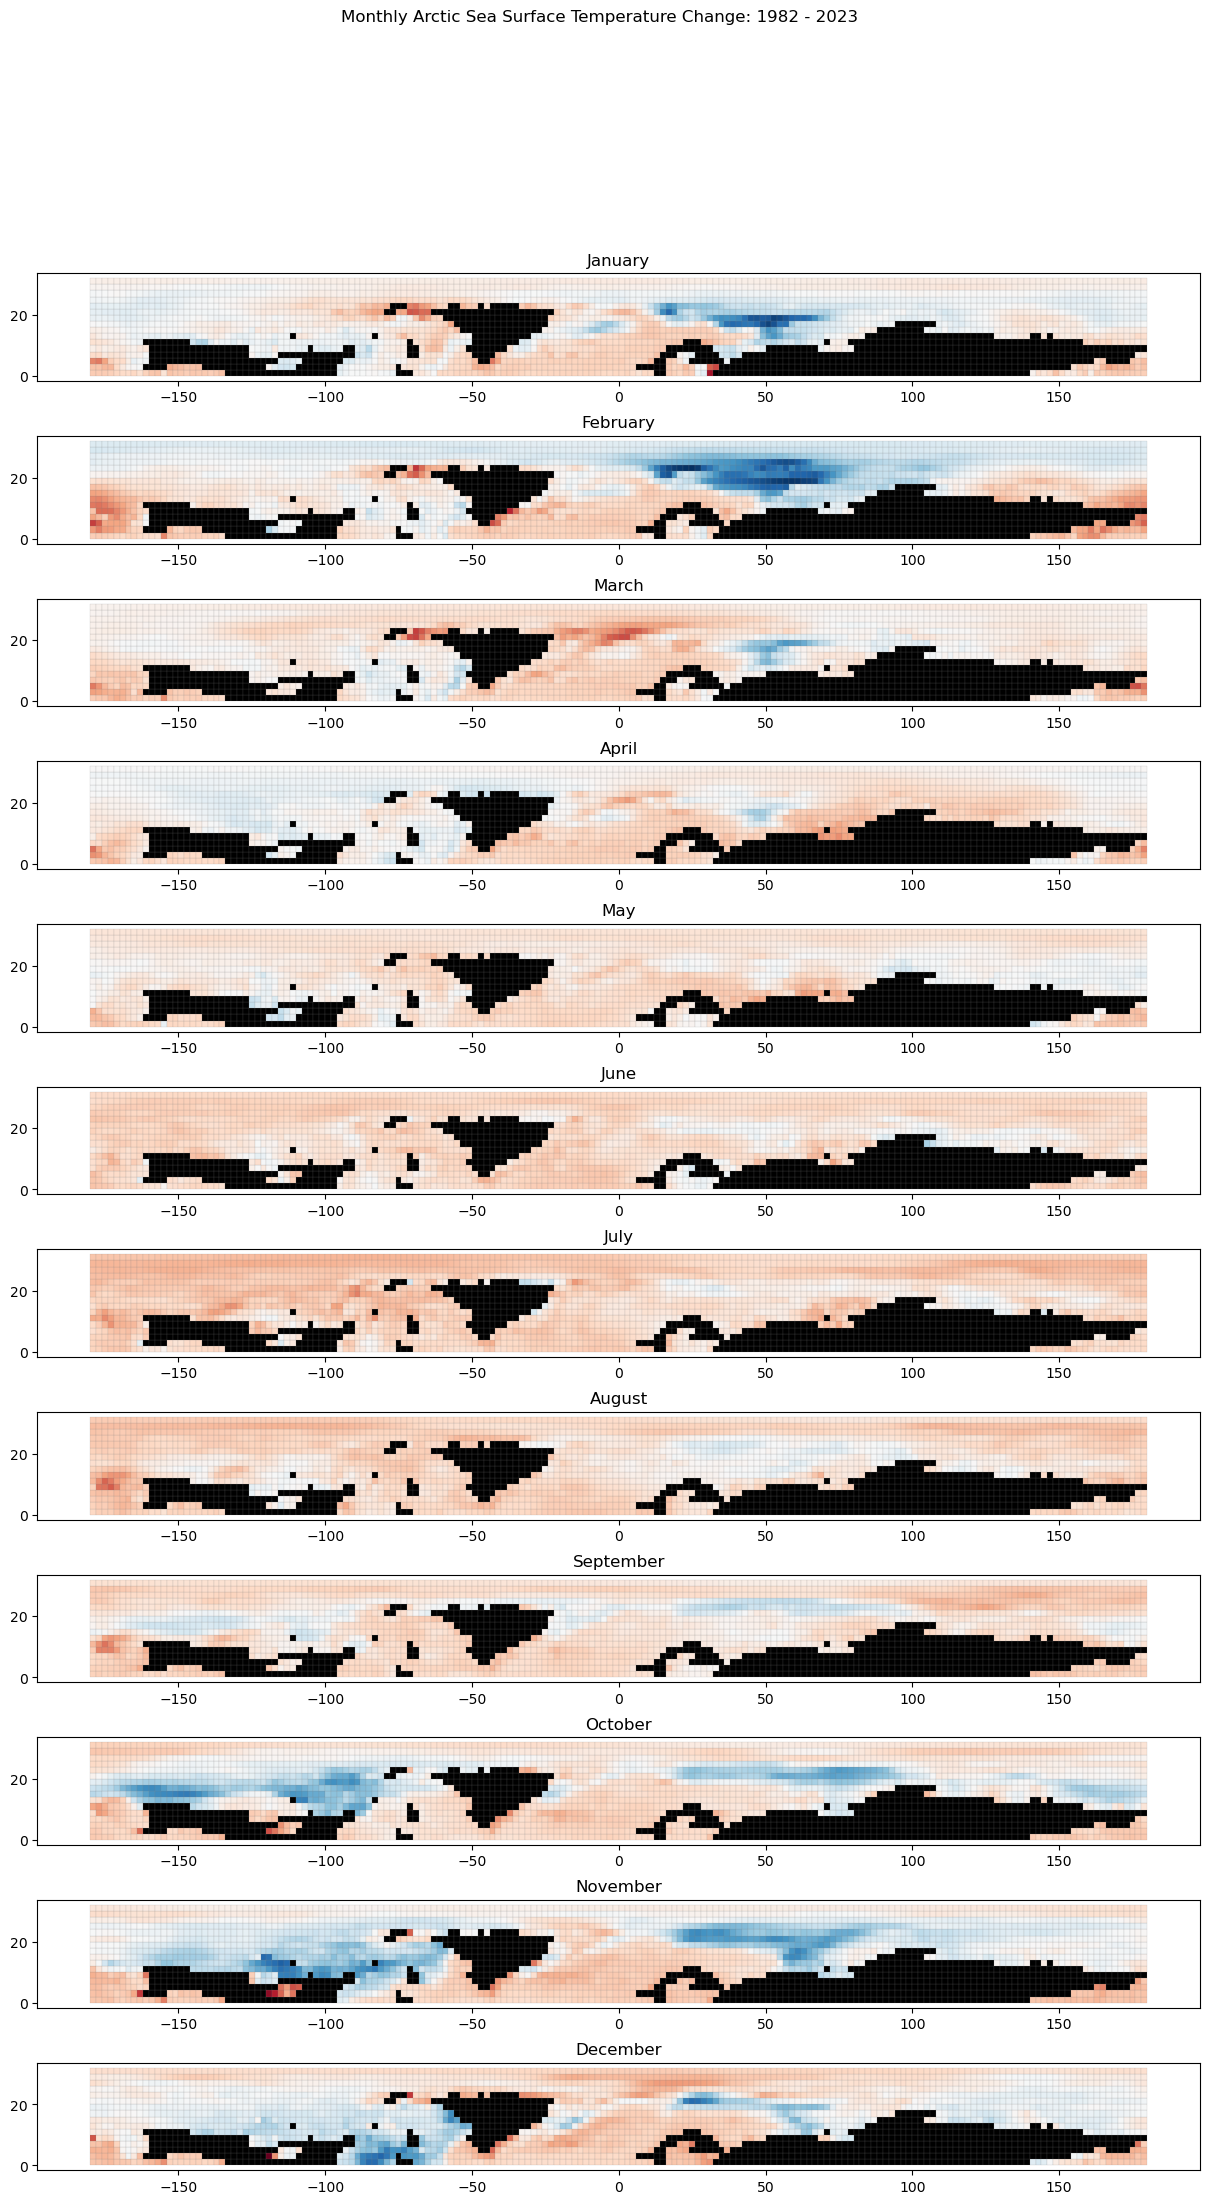

In [68]:
fig2, axes2 = plt.subplots(rows, columns, figsize=(15, 25))
axes_flat = axes2.flatten()

for m in range(1, 13):

    ax = axes_flat[m - 1]

    merged_monthly = merged[merged['MOY'] == m]
        
    gdf = merged_monthly.to_crs(epsg=4326)
    gdf.plot(color=gdf['fill_sst_diff'], 
             edgecolor='gray', 
             ax=ax, 
             linewidth=0.1)
    
    ax.set_title(f"{month_dict[m]}")

fig2.suptitle("Monthly Arctic Sea Surface Temperature Change: 1982 - 2023")
plt.show()

Above, we have an area-corrected graphic depicting the changes in sea surface temperature for each month between 1982 and 2024. Red represents increases in sea surface temperature, while blue represents decreases (little to no change regions are represented by white) There is a clear pattern of decreasing temperatures above Canada and Russia in the winter months, likely driven by melting sea ice (see next section) and increases in overall temperatures during the summer months. This shows the significant disruption in temperature patterns in polar regions, which can affect marine life, human society, and other climate systems in unpredictable ways (like the polar jet stream). 

*Note that the continents above are significantly distorted, but the area covered by each is accurate.*

## Sea Ice Coverage

Finally, let's look at sea ice coverage. Below, we use the annual states timeseries defined above to generate a total ice coverage by year plot.

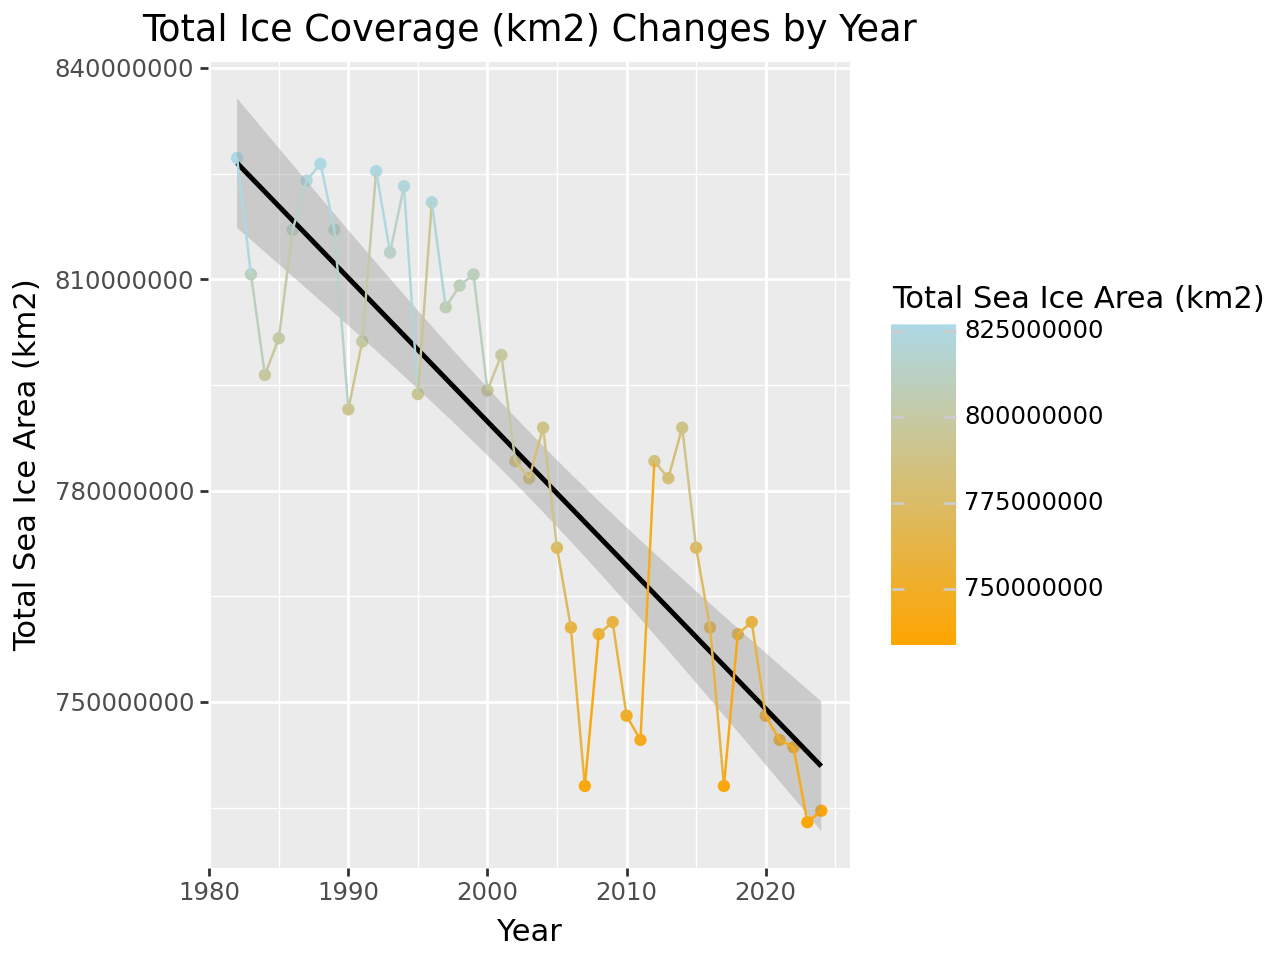

In [19]:
ice_coverage_plot = (ggplot(annual_stats, aes(x='Year', 
                                              y='Total Sea Ice Area (km2)', 
                                              color='Total Sea Ice Area (km2)')) 
            + geom_point() 
            + geom_smooth(method='lm') 
            + geom_line() 
            + labs(title = "Total Ice Coverage (km2) Changes by Year")
            + scale_color_gradient(low='orange', high='lightblue'))

ice_coverage_plot

We can clearly see the decline in sea ice since 1982 -- there has been a decrease in sea ice coverage by an average of around 8 million kilometers over the last four decades, with the sharpest declines appearing in the mid 2000s. While perhaps not as consistent as the sea surface temperature trends (the sea ice coverage appeared relatively constant during the years 1982-1995), it is still clearly decreasing with time. 

Below, we examine these trends on a monthly level.

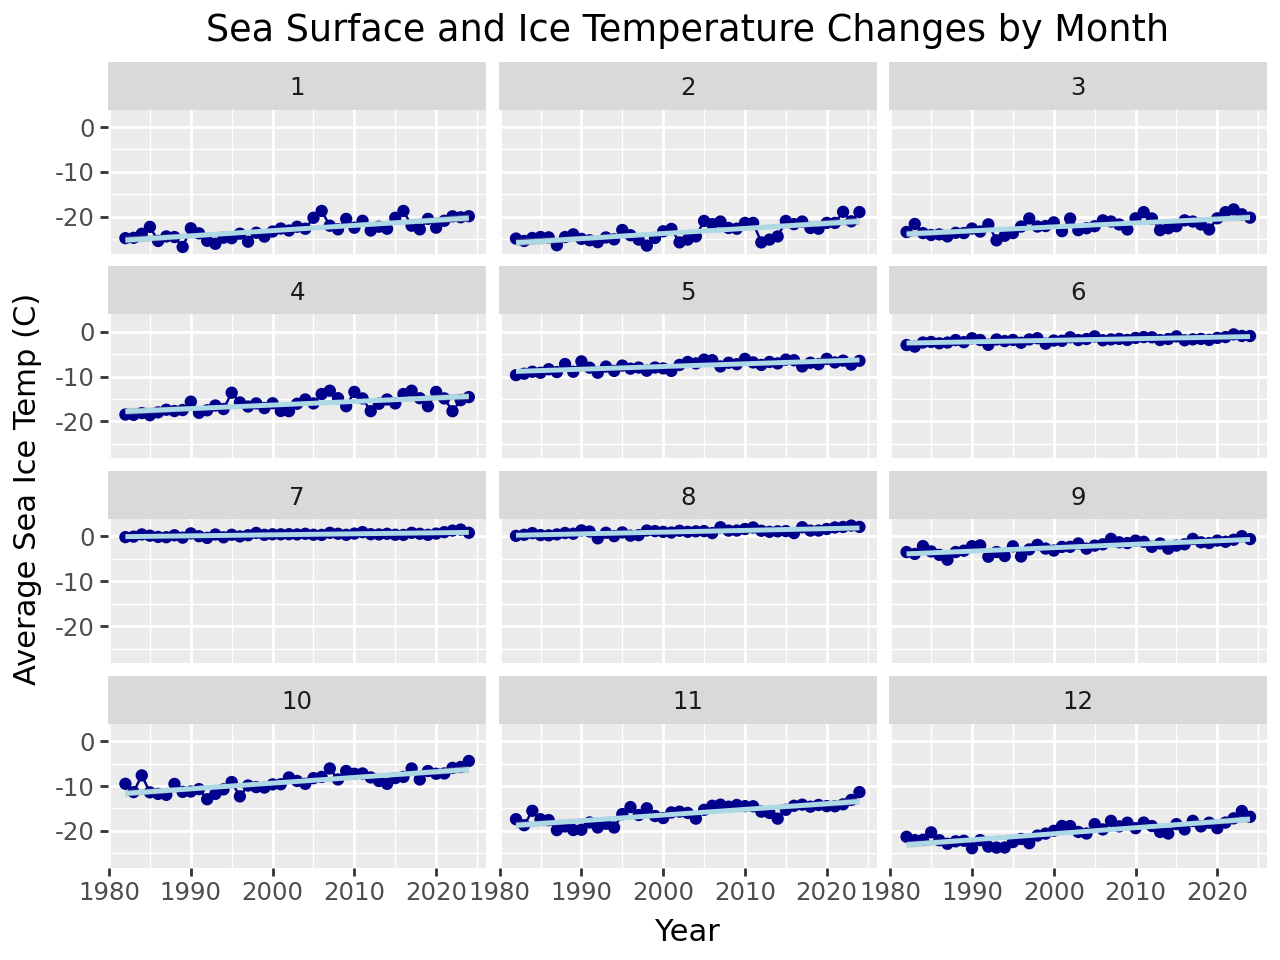

In [39]:
monthly_ice = (ggplot(monthly_stats, aes(x='Year', y='Total Sea Ice Area (km2)')) 
              + facet_wrap('MOY', ncol=3) + geom_point(color='darkblue') 
              + geom_line(color='darkblue') 
              + geom_smooth(method='lm', color="lightblue") 
              + labs(title = "Total Ice Coverage (km2) Changes by Month"))
monthly_st

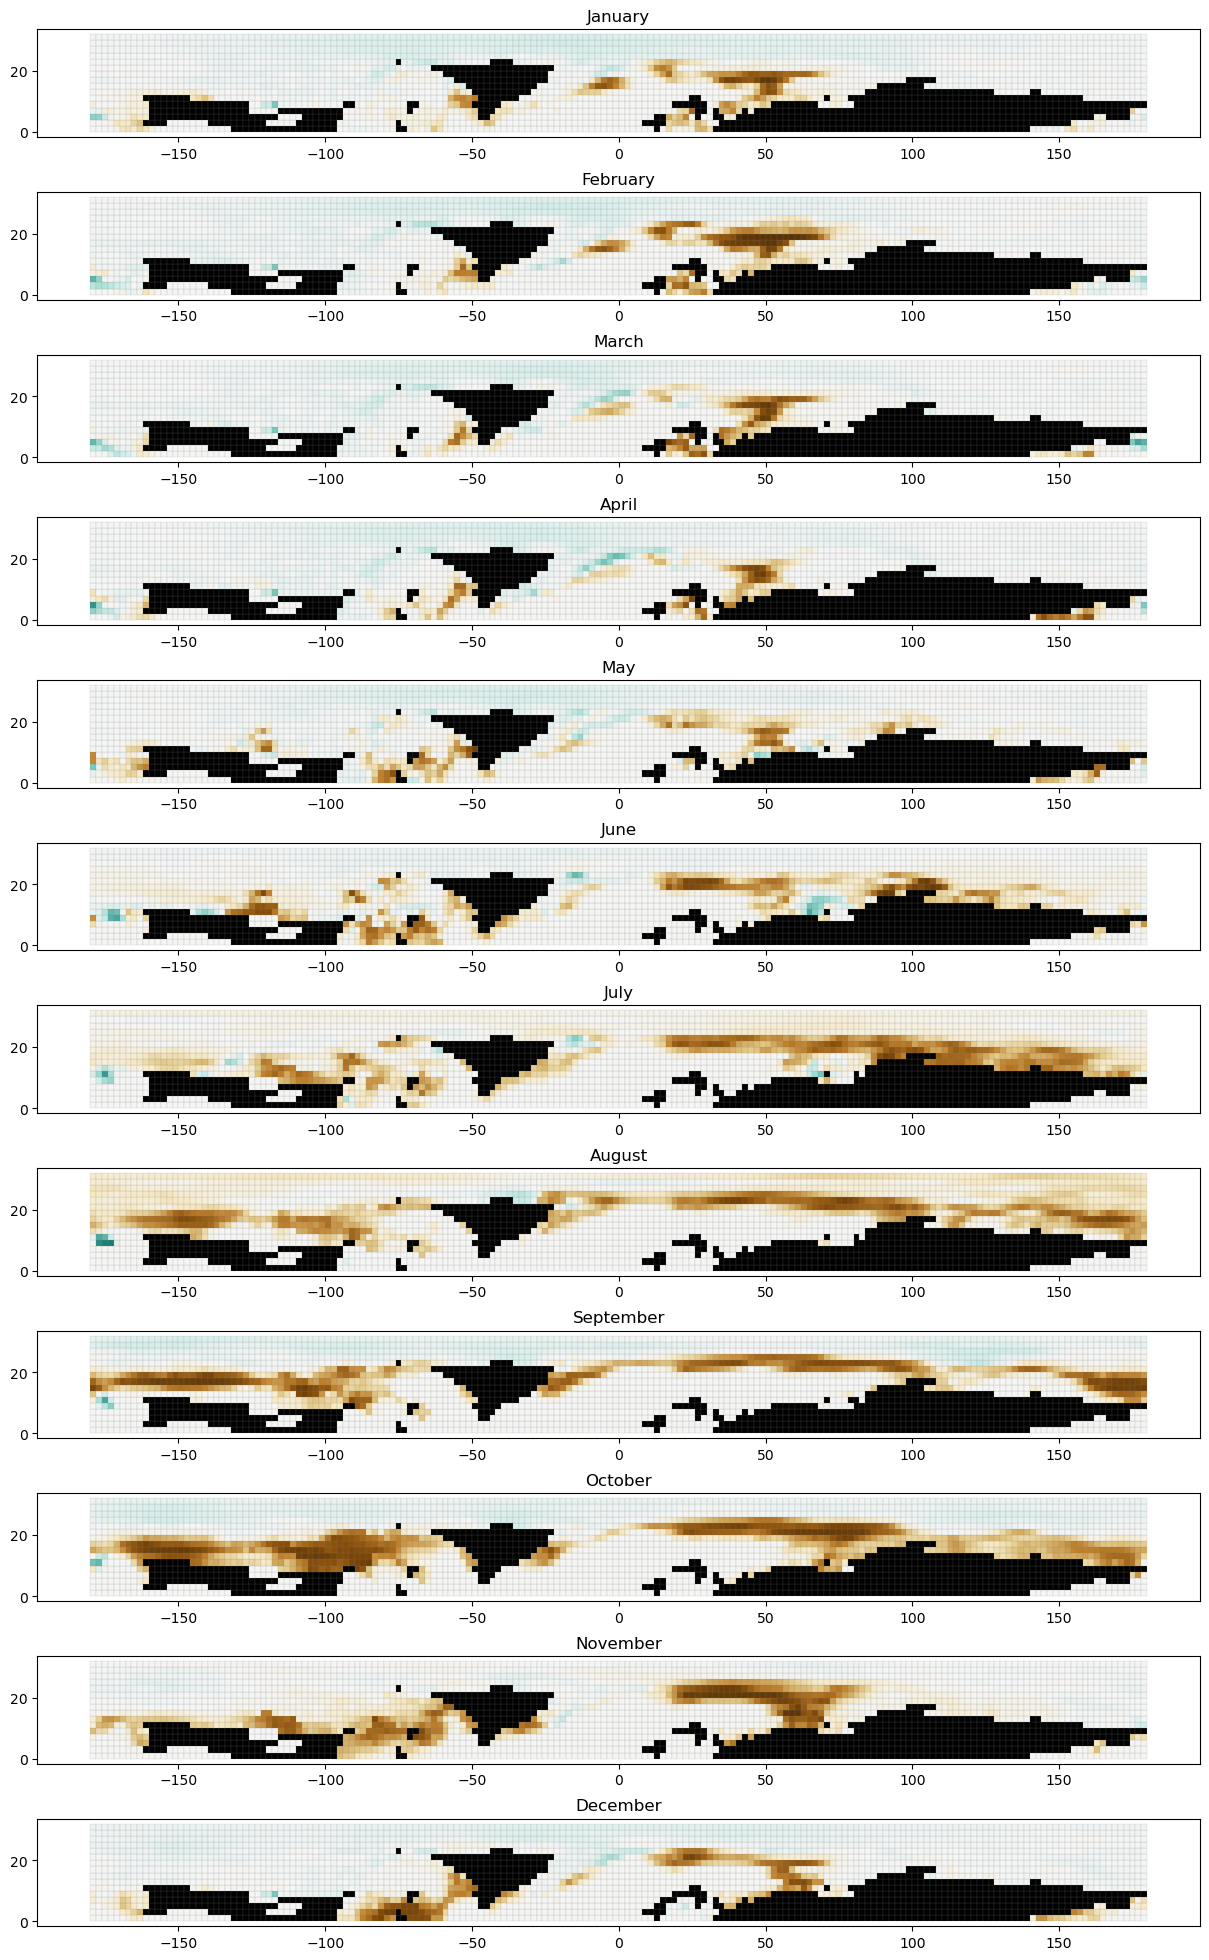

In [69]:
fig1, axes1 = plt.subplots(rows, columns, figsize=(15, 25))
axes_flat = axes1.flatten()

for m in range(1, 13):

    ax = axes_flat[m - 1]

    merged_monthly = merged[merged['MOY'] == m]
        
    gdf = merged_monthly.to_crs(epsg=4326)
    gdf.plot(color=gdf['fill_ice_diff'], 
             edgecolor='gray', 
             ax=ax, 
             linewidth=0.1)
    
    ax.set_title(f"{month_dict[m]}")

fig2.suptitle("Monthly Arctic Sea Surface Temperature Change: 1982 - 2023")
plt.show()

Above, we have an area-corrected graphic depicting the changes in sea surface temperature for each month between 1982 and 2024. Brown represents decreases in sea ice coverage, while light blue represents increases (little to no change regions are represented by white). The darkest colors on each end of the scale represent a change of -1 (there used to be 100% coverage and now there is 0%) or 1 (there used to be no coverage and now there is 100%). There is a clear pattern of decreasing coverage above Canada and Russia in the latter half of the year, which provides evidence that these changes are related to the cooling of the surface temperatures in these regions. While some high latitude regions show slight to moderate increased coverage in the late winter and early spring, the coverage across the region is overwhelmingly decreasing. This can have serious impacts on marine life in the arctic that relies on this sea ice, as well as global climate systems (including ocean circulation and sea level rise). 

*Note that the continents above are significantly distorted, but the area covered by each is accurate.*

Finally, this bonus automatically-updating graphic depicts the changes in sea ice coverage each year in the selected month (September, month 9, is selected by default). It takes up to 3-4 minutes to set up and another minute to run, but we found it to be an interesting data visualization for changes over time in the Arctic.

In [70]:
cmap = plt.get_cmap('Blues').reversed()
norm = Normalize(vmin=sst_ice_1982_2025['sea_ice_fraction'].min(), 
                 vmax=sst_ice_1982_2025['sea_ice_fraction'].max())

sst_ice_1982_2025['fill'] = sst_ice_1982_2025['sea_ice_fraction'].apply(lambda x: rgb2hex(cmap(norm(x))))

In [74]:
sst_ice_1982_2025.head(3)

,Long_2d,Lat_2d,sea_ice_fraction,analysed_st,MOY,Year,geom,fill
0,-179,1,0.000000,276.513200,1,1982,"POLYGON ((-180 0, -180 2, -178 2, -178 0, -180...",#08306b
1,-179,3,0.001760,275.496649,1,1982,"POLYGON ((-180 2, -180 4, -178 4, -178 2, -180...",#08306b
2,-179,5,0.238276,269.644432,1,1982,"POLYGON ((-180 4, -180 6, -178 6, -178 4, -180...",#1e6db2


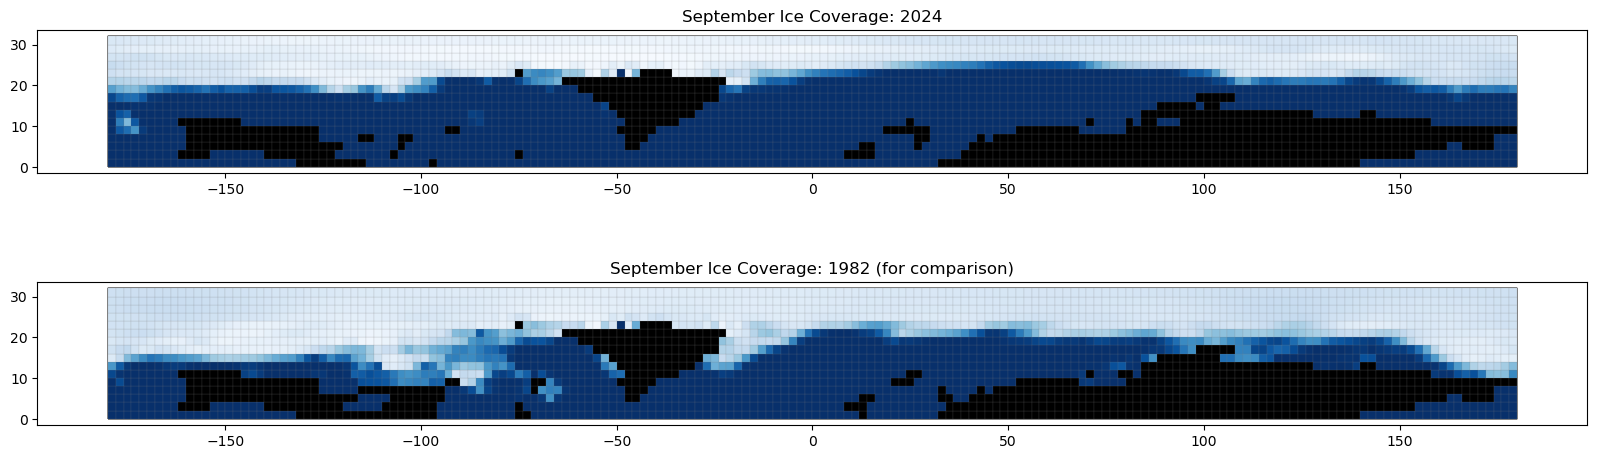

In [73]:
month = 9
df_for_month = sst_ice_1982_2025[sst_ice_1982_2025['MOY']==month]
df_for_month_1982 = df_for_month[df_for_month['Year'] == 1982]
gdf_for_month_1982 = gpd.GeoDataFrame(df_for_month_1982, geometry='geom', crs="EPSG:4326")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
ax2.set_title(f"{month_dict[month]} Ice Coverage: 1982")

for yr in np.arange(1982, 2025, 1):
    
    clear_output(wait=True)

    df_for_month_year = df_for_month[df_for_month['Year'] == yr]
    gdf = gpd.GeoDataFrame(df_for_month_year, geometry='geom', crs="EPSG:4326")

    gdf.plot(color=gdf['fill'], 
             edgecolor='gray', 
             ax=ax1, 
             linewidth=0.1),
    ax2.set_title(f"{month_dict[month]} Ice Coverage: 1982 (for comparison)")

    gdf_for_month_1982.plot(color=gdf_for_month_1982['fill'], 
             edgecolor='gray', 
             ax=ax2, 
             linewidth=0.1),
    ax1.set_title(f"{month_dict[month]} Ice Coverage: {yr}")

    display(fig)
    plt.close(fig)
    time.sleep(0.1)

### Conclusion

Assessing the variability changes in surface air temperature, sea surface temperature, and sea ice concentration using satellite observations is critical in understanding the evolving melting of the Arctic region when in situ data are limited. As we navigated across the interfaces of the atmosphere, cryosphere, and ocean through these three variables, we noticed correlated trends that contribute to the positive feedback mechanisms of the ice-albedo feedback and Arctic amplification. We began evaluating the temporal and spatial changes of the surface air temperature from 1982 to 2021 and discovered that the air temperature progressively became warmer over the years. With warmer and moist atmospheric conditions, rainfalls become more prominent over snowfall, which is supported by our total water vapor and total precipitable ice water findings. Greater water vapor results in greater heat capacity, ultimately reinforcing the warming feedback loop and higher heat of vaporization. To bridge the gap between the atmosphere and cryosphere systems, we further explored the sea surface temperature and sea ice concentration. Our findings found the sea surface temperatures in the Arctic have increased significantly (3-4 degrees C) on average, with the most significant increases during winter months. The lower average changes during summer months may in part be driven by the overall increased melting of sea ice during the summer, which is a key factor driving colder ocean temperatures between Canada and Greenland and above Russia. While there are many other factors at play (including oceanic circulations that transport water to the Arctic from the Antarctic and the equator), these two climate change observations are closely related and have critical implications for how the Earth will continue to be impacted by climate change.

## AI Use Statement

While most of this code is our own (with the extensive help of Stack Overflow), we did use Google Gemini to assist in the programming of some of our more complicated data processing steps and for troubleshooting. The importation of files using xarray was beyond the scope of our knowledge, so we provided a detailed description of what we wanted the code to do. We then checked our code and its outputs against the appropriate libraries to ensure that the AI was not hallucinating or pointing us towards an illegitimate data source. In other areas of the notebook, our primary use of AI was to attempt to write the code on our own, and when it resulted in errors that were difficult for us to interpret and/or fix (after several manual troubleshooting steps), we copy-and pasted our code into Google Gemini along with a shortened error message, and any relevant information about what we were trying to accomplish. It often took several iterations of this process to get the code in working condition, but we nevertheless found the use of Gemini to be helpful for the otherwise frustrating and excessively time-consuming task of troubleshooting code. 

In our use of AI, we tried to be conscious of the dangers of AI hallucination, the environmental impacts of the immense computational power to run these programs, and the social impacts of these new technologies that are primarily placed on marginalized communities in the US and around the world. Therefore, we only used it when the problem was not something we were prepared to solve on our own after putting in significant effort and time.